### VLM-Lens: A Minimal Tutorial

This notebook demonstrates the setup and usage of VLM-Lens via a minimal example. For full documents, see [VLM-Lens Documentation](https://compling-wat.github.io/vlm-lens/).

### Part I. Get Started: Environment Setup
1. First, clone this repository:
    ```bash
    git clone https://github.com/compling-wat/vlm-lens.git
    cd vlm-lens
    ```

2. It is highly recommended to use a virtual environment through either `venv` or `conda`. 
    - Using `venv`:
        ```bash
        python3 -m venv ".venv/vlm-lens-base" --prompt "vlm-lens-base"
        source .venv/vlm-lens-base/bin/activate
        ```
    
    - Using `conda`:
        ```bash
        conda create -n vlm-lens-base python=3.11
        conda activate vlm-lens-base
        ```

3. Install the required packages. Different VLMs usually have different environment requirements---we provide the corresponding setup in `envs/` (tested on Ubuntu 24.04). If a model does not have a corresponding environment file listed there, it should be compatible with the base environment (`envs/base`). In this tutorial, we will go with the base environment:
    ```bash
    pip install -r envs/base/requirements.txt
    ``` 

4. To run this notebook, you will also need to install `ipykernel`:
    ```bash
    pip install ipykernel
    ```

The following commands in this notebook will assume that you have activated the virtual environment.

### Part II. Core Functionality: Extracting VLM Features of Images and Texts
Now we will see how to extract features of images and texts using the VLMs. We assume the images and texts are both stored in a huggingface dataset, where

- The images are stored in a column named `image` (of type `PIL.PngImagePlugin.PngImageFile`).
- The texts are stored in a column named `prompt` (of type `str`).

There can be additional columns that do not affect the feature extraction, but maybe useful for later analysis, e.g., the index or label of an example.
Now let's load a minimal dataset, `compling/vlm-lens-example`, for demonstration:

In [1]:
import datasets
from pprint import pprint
dataset = datasets.load_dataset('compling/vlm-lens-example')
pprint(dataset.column_names)

{'boolean': ['id', 'prompt', 'label', 'image'],
 'color': ['id', 'prompt', 'label', 'image'],
 'material': ['id', 'prompt', 'label', 'image'],
 'number': ['id', 'prompt', 'label', 'image'],
 'shape': ['id', 'prompt', 'label', 'image'],
 'size': ['id', 'prompt', 'label', 'image']}


This dataset has six splits: `boolean`, `color`, `material`, `number`, `shape`, and `size`, each sampled from the full CLEVR-based feature probing dataset (`compling/CLEVR_categories`). The original dataset was used for probing the knowledge of VLMs about different object attributes. Here we will only use them to demonstrate the feature extraction functionality of VLM-Lens.

Each split has four columns: `id`, `image`, `prompt`, and `label`. An example in the `color` split is shown below:

Data structure:
{'id': 'CLEVR_val_000000.png',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=480x320 at 0x7FE42663C710>,
 'label': 'purple',
 'prompt': 'What is the color of the large shiny sphere?'}
Image:


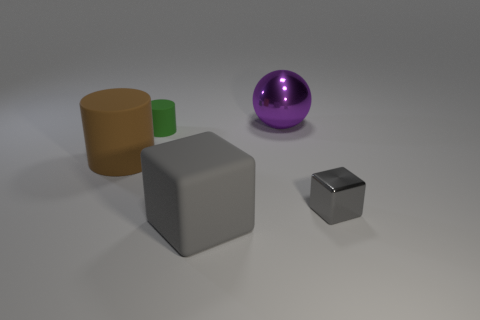

In [2]:
example = dataset['color'][0]
print('Data structure:')
pprint(example)

print('Image:')
display(example['image'])

To extract features using a dataset, we will need a YAML configuration file that specifies the model and other settings. We provide a few example configuration files in the `configs/models` directory. 
Here we will use the `openai/clip-vit-base-patch32` model as an example, the following content will be saved as `tmp/demo.yaml`:

```yaml
architecture: clip
model_path: openai/clip-vit-base-patch32
model:
  - torch_dtype: auto
dataset:
  - dataset_path: compling/vlm-lens-example
  - dataset_split: color
output_db: tmp/demo.db
pooling_method: mean
modules:
  - text_model.encoder.layers.5.layer_norm1
  - text_model.encoder.layers.11.layer_norm1
```

These keys are explained as follows:
- `architecture`: the architecture of the model, encoded in `src/models/configs.py`. It should be one of the supported architectures listed there.
- `model_path`: the path to the model. It can be a local path or a huggingface model name.
- `model`: additional arguments to be passed to the model when performing the inference. 
- dataset:
  - `dataset_path`: the path to the dataset. It can be a local path or a huggingface dataset name.
  - `dataset_split`: the split of the dataset to be used. Currently only one split is supported if there are multiple; if not specified, the default dataset will be used.
- `output_db`: the path to the output database file (in SQLite format) that will be created.
- `pooling_method`: the method to pool the features from different tokens. It can be one of `mean`, `max`, or `None`. If `None` is specified, the features of all tokens will be saved.
- `modules`: a list of module names (as in the model's state dict) from which the features will be extracted. If not specified, only the final layer's features will be extracted. 

In [3]:
import os
os.makedirs('tmp', exist_ok=True)

with open('tmp/demo.yaml', 'w') as f:
    f.write("""
architecture: clip
model_path: openai/clip-vit-base-patch32
model:
  - torch_dtype: auto
dataset:
  - dataset_path: compling/vlm-lens-example
  - dataset_split: color
output_db: tmp/demo.db
pooling_method: mean
modules:
  - text_model.encoder.layers.5.layer_norm1
  - text_model.encoder.layers.11.layer_norm1
""")

Now we can run the feature extraction using the following command, and the features will be saved in `tmp/demo.db`, in a table named `tensors`:

If you don't have a GPU available, you can add `--device cpu` to the command to run it on CPU, but it will be much slower.

In [4]:
! python ../src/main.py --config tmp/demo.yaml

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Running forward hooks on data: 100%|████████████| 10/10 [00:01<00:00,  7.45it/s]


### Part III. Inspecting the Extracted Features
Next, let's inspect the extracted features. The feature storage, `tmp/demo.db`, is an SQLite database, which can be easily accessed using the `sqlite3` command line tool or any SQLite client. 
Here, we also offer a minimal feature loader function in `src/utils.py` that executes a SQL query to select and return all related tensors from the specified database and table:
```Python
def select_tensors(
        db_path: str,
        table_name: str,
        keys: List[str] = ['layer', 'pooling_method', 'tensor_dim', 'tensor'],
        sql_where: Optional[str] = None,
        ) -> List[Any]:
    """Select and return all tensors from the specified SQLite database and table.

    Args:
        db_path (str): Path to the SQLite database file.
        table_name (str): Name of the table to query.
        keys (List[str]): List of keys to select from the database.
        sql_where (str): Optional SQL WHERE clause to filter results.

    Returns:
        List[Any]: A list of tensors retrieved from the database.
    """
```

In [5]:
import sys
sys.path.insert(0, '..')
from src.utils import select_tensors
data = select_tensors('tmp/demo.db', 'tensors', keys=['layer', 'pooling_method', 'tensor_dim', 'tensor'], sql_where='where layer="text_model.encoder.layers.11.layer_norm1"')
print(f'Selected {len(data)} rows from the database.')
print('A row looks like:')
row = data[0]
for k, v in row.items():
    print(f'Key: {k}\t{type(v)}\t\tValue shape (if tensor): {v.shape if hasattr(v, "shape") else "N/A"}')

Selected 10 rows from the database.
A row looks like:
Key: layer	<class 'str'>		Value shape (if tensor): N/A
Key: pooling_method	<class 'str'>		Value shape (if tensor): N/A
Key: tensor_dim	<class 'int'>		Value shape (if tensor): N/A
Key: tensor	<class 'torch.Tensor'>		Value shape (if tensor): torch.Size([1, 512])


The above script selects all rows from the `tensors` table where the `layer` is `text_model.encoder.layers.11.layer_norm1`, and retrieves the columns `layer`, `pooling_method`, `tensor_dim`, and `tensor`. The selected data is stored in the `data` variable as a list of dictionaries, where each dictionary corresponds to a row in the database.

For a more comprehensive picture what this database looks like, you can either inspect it using any SQLite client, or consult `tutorial/notebooks/database.ipynb`. 

### Part IV. Example Downstream Analysis: PCA Visualization
Finally, we can perform some downstream analysis using the extracted features. As an example, we will perform PCA on the features from a specific layer and visualize them using a scatter plot. 
The following code demonstrates this process. Before executing the Python code, we need to install the required package:

In [6]:
! pip install scikit-learn matplotlib

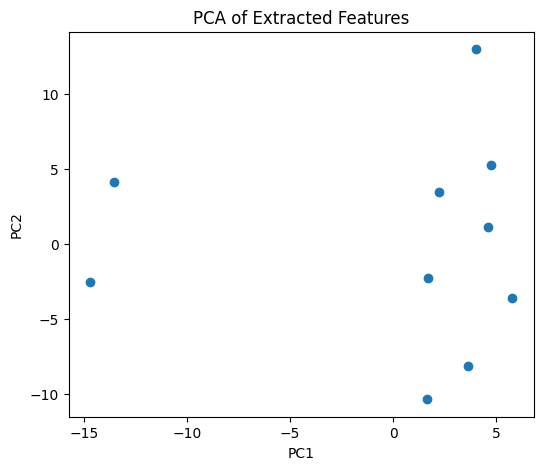

In [7]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Stack all tensors into a single numpy array
X = torch.cat([row['tensor'] for row in data], dim=0).numpy()

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA of Extracted Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Finally, let's clean up the temporary files created during this tutorial:

In [8]:
! rm -rf tmp/

For more supported functionalities, such as probing, check out scripts in `src/probe` and their associated documentation. Happy coding!